# Signet Supply Model

## Library

In [1]:
import pypyodbc as podbc
import pandas as pd
from pandas import DataFrame
import datetime
from datetime import date
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import plotly.express as px

import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

## Load Data

In [ ]:
# # NOTE: Signet Supply Report
# #      Signet Utilization Report

# # Load utilization data
# df_Utilization= pd.read_excel(r"Signet_utilization_score.xlsx", sheet_name="Utilization Detail")

# # Load supply data
# df_Supplyorder= pd.read_excel(r"Signet_supply order.xlsx", sheet_name="Supply")

In [2]:
# NOTE: Signet Supply Report
#      Signet Utilization Report

# Load utilization data
df_Utilization= pd.read_excel(r"Signet_Summary.xlsx", sheet_name="Report 9", header = 1)
df_Utilization = df_Utilization.drop('Unnamed: 0', axis = 1)

# Load supply data
# df_Supplyorder= pd.read_excel(r"Signet_supply order.xlsx", sheet_name="Supply")

C:\Users\JSpradlin\AppData\Roaming\Python\Python312\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Supply

### Data Cleaning and Feature Engineering

In [ ]:
df_Supplyorder['Brand'] = df_Supplyorder['Brand'].str.strip()
df_Supplyorder['Model (Attr)'] = df_Supplyorder['Model (Attr)'].str.strip()

# Identifying the numerical and categorical columns in the supply data
supply_numerical_cols = df_Supplyorder.select_dtypes(include='number').columns.tolist()
supply_categorical_cols = df_Supplyorder.columns[~df_Supplyorder.columns.isin(supply_numerical_cols)].to_list()

df_Supplyorder['month'] = pd.to_datetime(df_Supplyorder['Created On']).dt.month
df_Supplyorder['day'] = pd.to_datetime(df_Supplyorder['Created On']).dt.day
df_Supplyorder['day_num'] = pd.to_datetime(df_Supplyorder['Created On']).dt.day_of_week

In [46]:
# grouping the supply data
df_supply_group = df_Supplyorder.groupby(supply_categorical_cols).sum().reset_index()

df_supply_group_special = df_Supplyorder[['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 'Line Count']].groupby(
    ['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num',]
).sum().reset_index()

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_supply_group_special['brand_encoded'] = le.fit_transform(df_supply_group_special['Brand'])
df_supply_group_special['color_encoded'] = le.fit_transform(df_supply_group_special['Color'])
df_supply_group_special['model_encoded'] = le.fit_transform(df_supply_group_special['Model (Attr)'])
df_supply_group_special['ship_to_name_encoded'] = le.fit_transform(df_supply_group_special['Ship To Name'])

In [48]:
supply_group_features = ['month', 'day',
       'day_num', 'Total Read', 'ZYIELD', 'brand_encoded',
       'color_encoded', 'model_encoded', 
       'ship_to_name_encoded'
       ]

#### Supply Group Model

In [49]:
# Supply group model

target = 'Line Count'

# Use only the training portion for tuning
train_data = df_supply_group_special[(df_supply_group_special['Created On'] < '2025-01-01') ]
test = df_supply_group_special[df_supply_group_special['Created On'] >= '2025-01-01']

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'min_sum_hessian_in_leaf': 1e-3,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'force_row_wise': True
    }

    rmses = []

    for train_idx, val_idx in tscv.split(train_data):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        lgb_train = lgb.Dataset(train_fold[supply_group_features], label=train_fold[target], categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])
        lgb_val = lgb.Dataset(val_fold[supply_group_features], label=val_fold[target], reference=lgb_train)

        model = lgb.train(params, lgb_train, valid_sets=[lgb_val], )
        preds = np.clip(model.predict(val_fold[supply_group_features]), 0, None)
        rmse = np.sqrt(mean_squared_error(val_fold[target], preds))
        rmses.append(rmse)

    return np.mean(rmses)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})

# Train on full training set
train_final = df_supply_group_special[df_supply_group_special['Created On'] < '2025-01-01']
test_final = df_supply_group_special[df_supply_group_special['Created On'] >= '2025-01-01']

lgb_train = lgb.Dataset(train_final[supply_group_features], label=train_final[target], categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])
lgb_test = lgb.Dataset(test_final[supply_group_features], label=test_final[target], reference=lgb_train)

model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test], )

# Evaluate
preds = np.clip(model.predict(test_final[supply_group_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

[I 2025-07-29 13:52:47,334] A new study created in memory with name: no-name-d47338ed-9ebb-4737-8f8f-7bca7b8ce576
[I 2025-07-29 13:52:49,530] Trial 0 finished with value: 0.5417564916051982 and parameters: {'learning_rate': 0.04296637886559061, 'num_leaves': 49, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.8948120888215659, 'bagging_fraction': 0.9087632782827403, 'lambda_l1': 1.8148990162603507, 'lambda_l2': 3.076468374998758}. Best is trial 0 with value: 0.5417564916051982.
[I 2025-07-29 13:52:51,576] Trial 1 finished with value: 0.5464997825734934 and parameters: {'learning_rate': 0.08734569541763687, 'num_leaves': 20, 'max_depth': 4, 'min_data_in_leaf': 29, 'feature_fraction': 0.8182875255083816, 'bagging_fraction': 0.6010576852308607, 'lambda_l1': 2.848890455260613, 'lambda_l2': 1.9704509870211524}. Best is trial 0 with value: 0.5417564916051982.
[I 2025-07-29 13:52:57,150] Trial 2 finished with value: 0.5301388220106635 and parameters: {'learning_rate': 0.09137761

Best Parameters: {'learning_rate': 0.018740345337200457, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.6976437307532328, 'bagging_fraction': 0.7917161621958948, 'lambda_l1': 4.308193475027047, 'lambda_l2': 2.3199018428663876, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0542
Final Model RMSE: 0.2412
Final Model R^2: 0.8583


Best Parameters: {'learning_rate': 0.018740345337200457, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.6976437307532328, 'bagging_fraction': 0.7917161621958948, 'lambda_l1': 4.308193475027047, 'lambda_l2': 2.3199018428663876, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0542
Final Model RMSE: 0.2412
Final Model R^2: 0.8583

##### Supply Group Feature Importance

In [50]:
# Extract feature importances and feature names
importances = model.feature_importance()
feature_names = model.feature_name()

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot with Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', template = 'plotly_dark', 
             title='Feature Importance (LightGBM)',
             labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
            #  height=800
             )

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

##### Supply Group Actual vs Predicted

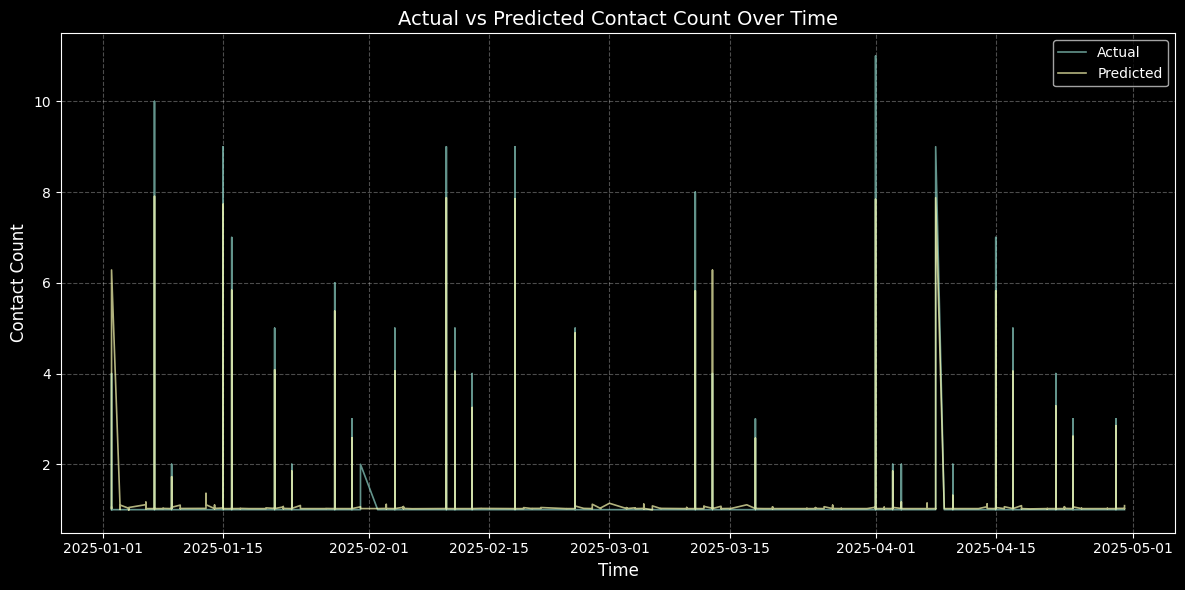

In [51]:
# Plot actual vs predicted
plot_df = test[['Created On', 'Line Count']].copy()
plot_df['Predicted'] = preds
plot_df = plot_df.rename(columns={'Line Count': 'Actual'})

plot_df = plot_df.sort_values('Created On')

plot_df_melted = plot_df.melt(id_vars='Created On', value_vars=['Actual', 'Predicted'],
                              var_name='Type', value_name='Line Count')

import matplotlib.pyplot as plt

# Enable dark mode
plt.style.use('dark_background')

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)  # High resolution
plt.plot(plot_df['Created On'], plot_df['Actual'], label='Actual', alpha=0.7, linewidth=1.2)
plt.plot(plot_df['Created On'], plot_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1.2)

# Customize labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Contact Count', fontsize=12)
plt.title('Actual vs Predicted Contact Count Over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

##### Supply Group Correlation Matrix Heatmap

In [52]:
# Select the relevant numeric columns
columns = ['month', 'day', 'day_num', 'Total Read', 'ZYIELD', 
           'brand_encoded', 'color_encoded', 'model_encoded', 
           'ship_to_name_encoded', 'Line Count']

# Filter the DataFrame
dfsupply = df_supply_group_special[columns]

# Compute the correlation matrix
correlation_matrix = dfsupply.corr()

# Round the correlation values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)


# Create the heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                text_auto=True,
                width=800, height=800,
                color_continuous_scale='RdBu_r',
                aspect='auto',
                zmin=-1, zmax=1,
                title='Correlation Matrix Heatmap', template='plotly_dark')

fig.show()


In [53]:
correlation_matrix['Line Count'].sort_values(ascending=False).reset_index().rename(columns={'index':'Feature'})

,Feature,Line Count
0,Line Count,1.00
1,Total Read,0.40
2,color_encoded,0.19
3,ZYIELD,0.09
4,day,0.02
5,month,-0.01
6,day_num,-0.02
7,model_encoded,-0.06
8,ship_to_name_encoded,-0.13
9,brand_encoded,-0.14


In [37]:
import joblib

# Save the model
joblib.dump(model, 'supply_model_r2_86.pkl')

['supply_model_r2_86.pkl']

## Utilization

<span style = "color>:gold"> Get `days since last order` data

### Feature Engineering

In [4]:
# Clean categorical data
df_Utilization['Brand'] = df_Utilization['Brand'].str.strip()
df_Utilization['Model (Attr)'] = df_Utilization['Model (Attr)'].str.strip()

# Identifying the numerical and categorical columns in the supply data
util_numerical_cols = df_Utilization.select_dtypes(include='number').columns.tolist()
util_categorical_cols = df_Utilization.columns[~df_Utilization.columns.isin(util_numerical_cols)].to_list()

# create month and day features
df_Utilization['month'] = pd.to_datetime(df_Utilization['Created On']).dt.month
df_Utilization['day'] = pd.to_datetime(df_Utilization['Created On']).dt.day
df_Utilization['day_num'] = pd.to_datetime(df_Utilization['Created On']).dt.day_of_week

# create utilization feature
df_Utilization['Utilization Score'] = df_Utilization['Total AMV']/(df_Utilization['ZYIELD']/2)

# grouping the util data
df_util_group = df_Utilization.groupby(util_categorical_cols).sum().reset_index()

df_util_group_special = df_Utilization[['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 'Line Count','Utilization Score', 'Total AMV']].groupby(
    ['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num',]
).sum().reset_index()

# encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_util_group_special['brand_encoded'] = le.fit_transform(df_util_group_special['Brand'])
df_util_group_special['color_encoded'] = le.fit_transform(df_util_group_special['Color'])
df_util_group_special['model_encoded'] = le.fit_transform(df_util_group_special['Model (Attr)'])
df_util_group_special['ship_to_name_encoded'] = le.fit_transform(df_util_group_special['Ship To Name'])

### Training Features

In [5]:
# isolate training features
util_train_features = ['month', 'day',
       'day_num', 'Total Read', 'ZYIELD', 'brand_encoded',
       'color_encoded', 'model_encoded', 
       'ship_to_name_encoded', 'Utilization Score', 'Total AMV'
       ]

### Split Train and Test and Identify Target Feature

In [9]:
# Utilization model

target = 'Line Count'

# Use only the training portion for tuning
train_data = df_util_group_special[(df_util_group_special['Created On'] < '2025-01-01') ]
test = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

### Build Model and Hyperparameter Tuning

In [ ]:
# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'min_sum_hessian_in_leaf': 1e-3,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'force_row_wise': True
    }

    rmses = []

    for train_idx, val_idx in tscv.split(train_data):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        lgb_train = lgb.Dataset(train_fold[util_train_features], label=train_fold[target])
        lgb_val = lgb.Dataset(val_fold[util_train_features], label=val_fold[target], reference=lgb_train, categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])

        model = lgb.train(params, lgb_train, valid_sets=[lgb_val], )
        preds = np.clip(model.predict(val_fold[util_train_features]), 0, None)
        rmse = np.sqrt(mean_squared_error(val_fold[target], preds))
        rmses.append(rmse)

    return np.mean(rmses)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})

# Train on full training set
train_final = df_util_group_special[df_util_group_special['Created On'] < '2025-01-01']
test_final = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

lgb_train = lgb.Dataset(train_final[util_train_features], label=train_final[target])
lgb_test = lgb.Dataset(test_final[util_train_features], label=test_final[target], reference=lgb_train, categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])

model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test], )

# Evaluate
preds = np.clip(model.predict(test_final[util_train_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

[I 2025-07-31 11:55:12,189] A new study created in memory with name: no-name-56507198-3496-435b-9ad0-2af834c89dc5


[I 2025-07-31 11:55:14,640] Trial 0 finished with value: 0.5552714338137119 and parameters: {'learning_rate': 0.07521714051535311, 'num_leaves': 60, 'max_depth': 8, 'min_data_in_leaf': 12, 'feature_fraction': 0.7566665544889496, 'bagging_fraction': 0.9852800760989162, 'lambda_l1': 3.4275671038774207, 'lambda_l2': 0.8366471885627491}. Best is trial 0 with value: 0.5552714338137119.
[I 2025-07-31 11:55:15,586] Trial 1 finished with value: 0.5311467589786376 and parameters: {'learning_rate': 0.05443962515041998, 'num_leaves': 59, 'max_depth': 3, 'min_data_in_leaf': 30, 'feature_fraction': 0.6903574090818813, 'bagging_fraction': 0.9420128403570474, 'lambda_l1': 1.1756379371793808, 'lambda_l2': 1.5605877261047951}. Best is trial 1 with value: 0.5311467589786376.
[I 2025-07-31 11:55:16,738] Trial 2 finished with value: 0.5131504351032492 and parameters: {'learning_rate': 0.030735603185735462, 'num_leaves': 28, 'max_depth': 3, 'min_data_in_leaf': 35, 'feature_fraction': 0.8749597589011961, 'b

Best Parameters: {'learning_rate': 0.014632212434962998, 'num_leaves': 54, 'max_depth': 7, 'min_data_in_leaf': 13, 'feature_fraction': 0.6749643950122177, 'bagging_fraction': 0.8552178165046478, 'lambda_l1': 0.3176404965259343, 'lambda_l2': 4.964011723701186, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0614
Final Model RMSE: 0.1692
Final Model R^2: 0.9303


### Import Saved Model

In [13]:
import joblib

model = joblib.load('util_model_r2_93v2.pkl')

# Train on full training set
train_final = df_util_group_special[df_util_group_special['Created On'] < '2025-01-01']
test_final = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

# Evaluate
preds = np.clip(model.predict(test_final[util_train_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

# print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

Final Model MAE: 0.0614
Final Model RMSE: 0.1692
Final Model R^2: 0.9303


### Feature Importance

In [7]:
# Extract feature importances and feature names
importances = model.feature_importance()
feature_names = model.feature_name()

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot with Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', template = 'plotly_dark', 
             title='Feature Importance (LightGBM)',
             labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
            #  height=800
             )

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

### Actual vs Predicted

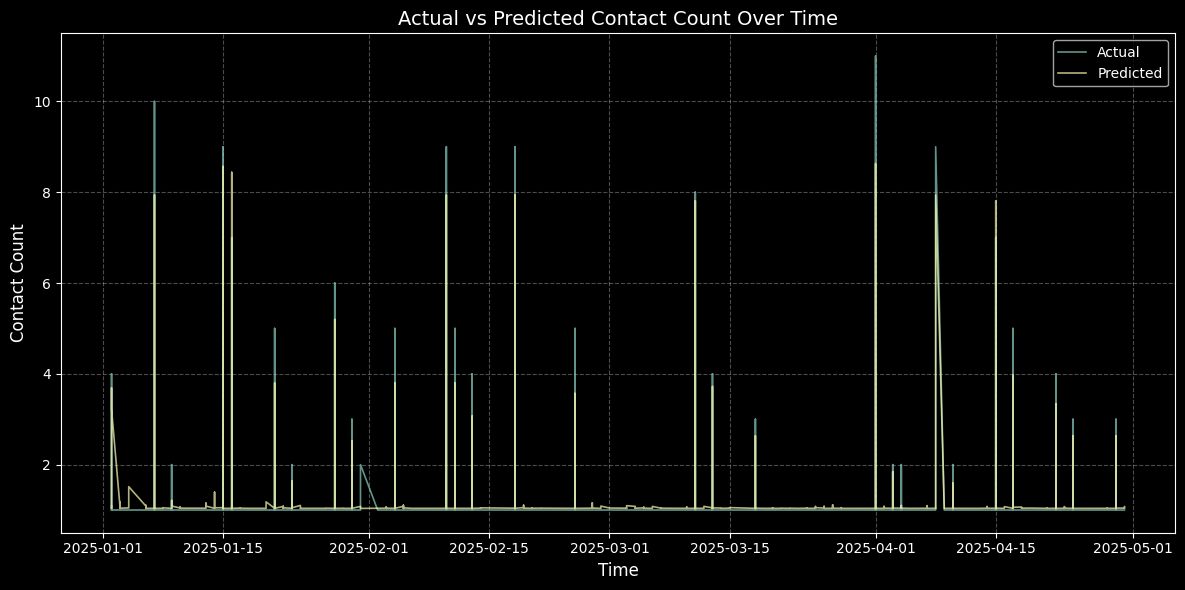

In [14]:
# Plot actual vs predicted
plot_df = test[['Created On', 'Line Count']].copy()
plot_df['Predicted'] = preds
plot_df = plot_df.rename(columns={'Line Count': 'Actual'})

plot_df = plot_df.sort_values('Created On')

plot_df_melted = plot_df.melt(id_vars='Created On', value_vars=['Actual', 'Predicted'],
                              var_name='Type', value_name='Line Count')

import matplotlib.pyplot as plt

# Enable dark mode
plt.style.use('dark_background')

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)  # High resolution
plt.plot(plot_df['Created On'], plot_df['Actual'], label='Actual', alpha=0.7, linewidth=1.2)
plt.plot(plot_df['Created On'], plot_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1.2)

# Customize labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Contact Count', fontsize=12)
plt.title('Actual vs Predicted Contact Count Over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Correlation Matrix

In [15]:
# Select the relevant numeric columns
columns = ['month', 'day', 'day_num', 'Total Read', 'ZYIELD', 
           'brand_encoded', 'color_encoded', 'model_encoded', 
           'ship_to_name_encoded', 'Utilization Score', 'Total AMV', 'Line Count']

# Filter the DataFrame
dfsupply = df_util_group_special[columns]

# Compute the correlation matrix
correlation_matrix = dfsupply.corr()

# Round the correlation values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)


# Create the heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                text_auto=True,
                width=800, height=800,
                color_continuous_scale='RdBu_r',
                aspect='auto',
                zmin=-1, zmax=1,
                title='Correlation Matrix Heatmap', template='plotly_dark')

fig.show()


In [16]:
correlation_matrix['Line Count'].sort_values(ascending=False).reset_index().rename(columns={'index':'Feature'})

,Feature,Line Count
0,Line Count,1.00
1,Total AMV,0.47
2,Total Read,0.40
3,Utilization Score,0.29
4,color_encoded,0.19
5,ZYIELD,0.09
6,day,0.02
7,month,-0.01
8,day_num,-0.02
9,model_encoded,-0.06


### Save Model

In [ ]:
# import joblib

# # Save the model
# joblib.dump(model, 'util_model_r2_93v2.pkl')

['util_model_r2_93v2.pkl']

### Forcasting

In [20]:
df_Utilization.head()

,Period month year,Created On,Total AMV,Total AMV (Avg),Days Since Creation,Color,Brand,Model (Attr),Ship To Name,Serial Number,Total Read,ZYIELD,Line Count,month,day,day_num,Utilization Score
0,202112,2021-12-09,NaN,0.0,1329,K,KAY JEWELERS,LXE460,KAY JEWELERS 1401,45145PHH2H80D,NaN,3500.0,1,12,9,3,NaN
1,202112,2021-12-13,NaN,0.0,1325,C,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
2,202112,2021-12-13,NaN,0.0,1325,K,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
3,202112,2021-12-13,NaN,0.0,1325,M,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
4,202112,2021-12-13,NaN,0.0,1325,Y,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN


In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from joblib import Parallel, delayed

def forecast_for_combination(combo_key, history, model, features, forecast_horizon=30):
    forecast_records = []

    # Determine the last timestamp
    last_timestamp = pd.to_datetime(history['Created On']).max()
    forecast_steps = forecast_horizon
    time_bins = [last_timestamp + timedelta(days=i + 1) for i in range(forecast_steps)]

    for time_bin in time_bins:
        new_row = {
            'Created On': time_bin,
            'Brand': combo_key[0],
            'Ship To Name': combo_key[1],
            'Color': combo_key[2],
            'month': time_bin.month,
            'day': time_bin.day,
            'day_num': time_bin.weekday(),
            'brand_encoded': history['brand_encoded'].iloc[0],
            'color_encoded': history['color_encoded'].iloc[0],
            'model_encoded': history['model_encoded'].iloc[0],
            'ship_to_name_encoded': history['ship_to_name_encoded'].iloc[0]
        }

        # # Lag features (days)
        # for lag in [1, 2, 3, 7]:
        #     lag_time = time_bin - timedelta(days=lag)
        #     lag_value = history.loc[history['Created On'] == lag_time, 'Line Count']
        #     new_row[f'lag_{lag}d'] = lag_value.values[0] if not lag_value.empty else 0.0

        # # Rolling stats (days)
        # for window in [3, 7]:
        #     window_data = history[(history['Created On'] > time_bin - timedelta(days=window)) &
        #                           (history['Created On'] < time_bin)]['Line Count']
        #     new_row[f'rolling_mean_{window}d'] = window_data.mean() if not window_data.empty else 0.0
        #     new_row[f'rolling_std_{window}d'] = window_data.std() if not window_data.empty else 0.0

        # Use median values for static numerical features
        new_row['Total Read'] = history['Total Read'].median()
        new_row['ZYIELD'] = history['ZYIELD'].median()
        new_row['Utilization Score'] = history['Utilization Score'].median()
        new_row['Total AMV'] = history['Total AMV'].median()

        # Create input and predict
        input_df = pd.DataFrame([new_row])[features]
        prediction = model.predict(input_df)[0]
        new_row['Line Count'] = prediction

        forecast_records.append(new_row)
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

    return forecast_records


def recursive_forecast_line_count(df_util_group_special, model, features, forecast_horizon=30, n_jobs=4):
    df_util_group_special['Created On'] = pd.to_datetime(df_util_group_special['Created On'])
    combinations = df_util_group_special[['Brand', 'Ship To Name', 'Color']].drop_duplicates()

    combo_histories = {
        (row['Brand'], row['Ship To Name'], row['Color']):
        df_util_group_special[(df_util_group_special['Brand'] == row['Brand']) &
                              (df_util_group_special['Ship To Name'] == row['Ship To Name']) &
                              (df_util_group_special['Color'] == row['Color'])].sort_values('Created On').copy()
        for _, row in combinations.iterrows()
    }

    results = Parallel(n_jobs=n_jobs)(
        delayed(forecast_for_combination)(combo_key, combo_histories[combo_key], model, features, forecast_horizon)
        for combo_key in tqdm(combo_histories.keys(), desc="Forecasting combinations")
    )

    all_forecasts = [row for combo_result in results for row in combo_result]
    return pd.DataFrame(all_forecasts)





In [ ]:
features = ['month', 'day', 'day_num', 'Total Read', 'ZYIELD',
            'brand_encoded', 'color_encoded', 'model_encoded',
            'ship_to_name_encoded', 'Utilization Score', 'Total AMV',
            ]

forecast_df = recursive_forecast_line_count(df_util_group_special, model, features, forecast_horizon=30, n_jobs=4)


Forecasting combinations: 100%|██████████| 5040/5040 [09:31<00:00,  8.81it/s]


In [24]:
df_Utilization

,Period month year,Created On,Total AMV,Total AMV (Avg),Days Since Creation,Color,Brand,Model (Attr),Ship To Name,Serial Number,Total Read,ZYIELD,Line Count,month,day,day_num,Utilization Score
0,202112,2021-12-09,NaN,0.0,1329,K,KAY JEWELERS,LXE460,KAY JEWELERS 1401,45145PHH2H80D,NaN,3500.0,1,12,9,3,NaN
1,202112,2021-12-13,NaN,0.0,1325,C,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
2,202112,2021-12-13,NaN,0.0,1325,K,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
3,202112,2021-12-13,NaN,0.0,1325,M,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
4,202112,2021-12-13,NaN,0.0,1325,Y,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37193,202504,2025-04-29,4459.0,297.0,92,Y,ZALES JEWELERS,C3300I,ZALES JEWELERS 8602,AAJT011204569,0.0,9000.0,1,4,29,1,0.990889
37194,202504,2025-04-30,28544.0,1902.0,91,C,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,9000.0,1,4,30,2,6.343111
37195,202504,2025-04-30,28544.0,1902.0,91,K,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,13000.0,1,4,30,2,4.391385
37196,202504,2025-04-30,28544.0,1902.0,91,Unknown,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,NaN,1,4,30,2,NaN


In [36]:
forecast_df['Month'] = forecast_df['Created On'].dt.strftime("%Y-%m")

In [30]:
forecast_df['Line Count Int'] = np.round(forecast_df['Line Count'], 0)

In [37]:
df_group = forecast_df[['Month', 'Ship To Name', 'Color', 'Line Count Int']].groupby(['Month', 'Ship To Name', 'Color',]).sum().reset_index()

In [38]:
px.bar(df_group[df_group['Month']>'2025-04'],
                x = 'Month', 
                y = 'Line Count Int', 
                color = 'Ship To Name',
                facet_row = 'Color', 
                template = 'plotly_dark', 
                height = 800)

In [40]:
df_Utilization

,Period month year,Created On,Total AMV,Total AMV (Avg),Days Since Creation,Color,Brand,Model (Attr),Ship To Name,Serial Number,Total Read,ZYIELD,Line Count,month,day,day_num,Utilization Score
0,202112,2021-12-09,NaN,0.0,1329,K,KAY JEWELERS,LXE460,KAY JEWELERS 1401,45145PHH2H80D,NaN,3500.0,1,12,9,3,NaN
1,202112,2021-12-13,NaN,0.0,1325,C,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
2,202112,2021-12-13,NaN,0.0,1325,K,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
3,202112,2021-12-13,NaN,0.0,1325,M,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
4,202112,2021-12-13,NaN,0.0,1325,Y,JARED,HPPW556XH,JARED 8590,CN79BBK15H,NaN,6000.0,1,12,13,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37193,202504,2025-04-29,4459.0,297.0,92,Y,ZALES JEWELERS,C3300I,ZALES JEWELERS 8602,AAJT011204569,0.0,9000.0,1,4,29,1,0.990889
37194,202504,2025-04-30,28544.0,1902.0,91,C,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,9000.0,1,4,30,2,6.343111
37195,202504,2025-04-30,28544.0,1902.0,91,K,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,13000.0,1,4,30,2,4.391385
37196,202504,2025-04-30,28544.0,1902.0,91,Unknown,JARED REPAIR SHOP,C3300I,JARED REPAIR SHOP 9283,AAJT011205960,27984.0,NaN,1,4,30,2,NaN


In [46]:
df_Utilization[(df_Utilization['Ship To Name']=='JARED 2420')]['Period month year'].value_counts()

Period month year
202301    2
202303    1
202304    1
202310    1
202401    1
202402    1
202404    1
202405    1
202409    1
202412    1
202503    1
202504    1
Name: count, dtype: int64